In [1]:
cd ..

/Users/a19370200/projects/tfidf_based_vectorizers


In [2]:
!pwd

/Users/a19370200/projects/tfidf_based_vectorizers


In [3]:
import numpy as np
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import re

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from spacy.lang.en import English
from spacy.tokenizer import Tokenizer
from string import punctuation
from model.vectorizers import Vectorizer

%matplotlib inline

In [4]:
sklearn.__version__

'0.24.2'

In [5]:
from sklearn.datasets import fetch_20newsgroups
cats = ['alt.atheism', 'sci.space']

ds_dict_train = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'), categories=cats)

X = ds_dict_train.get('data')
y = ds_dict_train.get('target')
classes_train = ds_dict_train.get('target_names')

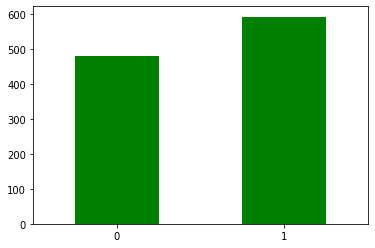

In [6]:
pd.Series(y).value_counts().sort_index().plot(kind='bar', rot=0, color='green');

In [7]:
pd.Series(y).value_counts().sort_index()

0    480
1    593
dtype: int64

In [8]:
len(X), len(y)

(1073, 1073)

## Stemming/Lemmatization

In [9]:
punctuation
punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'
spec_symbols = ['\n', '\t']

In [10]:
stemmer = PorterStemmer()
lemma = WordNetLemmatizer()
nlp = English()
tokenizer = Tokenizer(nlp.vocab)

def stem_text(sentence):
    tokens = []
    for token in tokenizer(sentence):
        if (token.text not in punct) and (token.text not in spec_symbols):
            tok = re.sub('[^a-zA-Z\d-]','',token.text)
            tokens.append(stemmer.stem(tok))
    return ' '.join(tokens)

def lemm_text(sentence):
    tokens = []
    for token in tokenizer(sentence):
        if (token.text not in punct) and (token.text not in spec_symbols):
            tok = re.sub('[^a-zA-Z\d-]','',token.text)
            tokens.append(lemma.lemmatize(tok))
    return ' '.join(tokens)

In [11]:
X_stem = [stem_text(sent) for sent in X]

## Train Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_stem, y, test_size=0.2, stratify=y, random_state=23)
len(X_train), len(X_test), len(y_train), len(y_test) 

(858, 215, 858, 215)

## TF-IDF

In [36]:
a = np.array([True, False])
np.array([0,0]) + a + a

array([2, 0])

In [13]:
vectorizer = Vectorizer(weight_method='idf_icf', tf_func='absolute')

In [14]:
X_train_vectorized = vectorizer.fit_transform(raw_documents=X_train, y=y_train)
X_train_vectorized.shape

transformers.fit X.shape:  (858, 11279)


(858, 11279)

In [15]:
X_test_vectorized = vectorizer.transform(X_test)
X_test_vectorized.shape

(215, 11279)

In [16]:
logreg_cv = LogisticRegression(
    class_weight='balanced',
    random_state=23
    )

logreg_cv.fit(X_train_vectorized, y_train)

LogisticRegression(class_weight='balanced', random_state=23)

In [17]:
y_pred = logreg_cv.predict(X_test_vectorized)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        96
           1       0.90      0.91      0.90       119

    accuracy                           0.89       215
   macro avg       0.89      0.89      0.89       215
weighted avg       0.89      0.89      0.89       215



## Some tests

In [18]:
# Lemma
y_pred = logreg_cv.predict(X_test_vectorized)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        96
           1       0.90      0.91      0.90       119

    accuracy                           0.89       215
   macro avg       0.89      0.89      0.89       215
weighted avg       0.89      0.89      0.89       215



In [19]:
# Stem
y_pred = logreg_cv.predict(X_test_vectorized)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        96
           1       0.90      0.91      0.90       119

    accuracy                           0.89       215
   macro avg       0.89      0.89      0.89       215
weighted avg       0.89      0.89      0.89       215



In [20]:
# Without preprocessing (20/80)
y_pred = logreg_cv.predict(X_test_vectorized)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        96
           1       0.90      0.91      0.90       119

    accuracy                           0.89       215
   macro avg       0.89      0.89      0.89       215
weighted avg       0.89      0.89      0.89       215

